In [295]:
import pandas as pf
import tensorflow as tf
gpus =tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [296]:
ds = tfds.load('tf_flowers',split='train')
dataiterator = ds.as_numpy_iterator()


In [297]:
dataiterator.next()

{'image': array([[[ 93, 122,  30],
         [ 90, 118,  31],
         [ 88, 118,  28],
         ...,
         [247,  77,  78],
         [253,  87,  87],
         [255,  76,  75]],
 
        [[ 98, 125,  30],
         [ 95, 124,  32],
         [ 96, 125,  32],
         ...,
         [247,  81,  83],
         [250,  86,  84],
         [252,  71,  64]],
 
        [[ 98, 126,  26],
         [101, 128,  31],
         [106, 132,  33],
         ...,
         [254,  81,  85],
         [254,  79,  76],
         [252,  55,  47]],
 
        ...,
 
        [[ 35,  51,   6],
         [ 21,  49,   0],
         [ 30,  57,   6],
         ...,
         [224, 239,  78],
         [192, 208,  50],
         [ 88,  54,  53]],
 
        [[ 65,  73,  32],
         [ 20,  46,   0],
         [ 22,  48,   0],
         ...,
         [230, 236,  74],
         [230, 246,  62],
         [ 88,  57,  36]],
 
        [[ 95,  97,  60],
         [ 15,  41,   0],
         [ 23,  51,   3],
         ...,
         [210, 224,

In [298]:
np.squeeze(dataiterator.next()['image']).shape

(212, 320, 3)

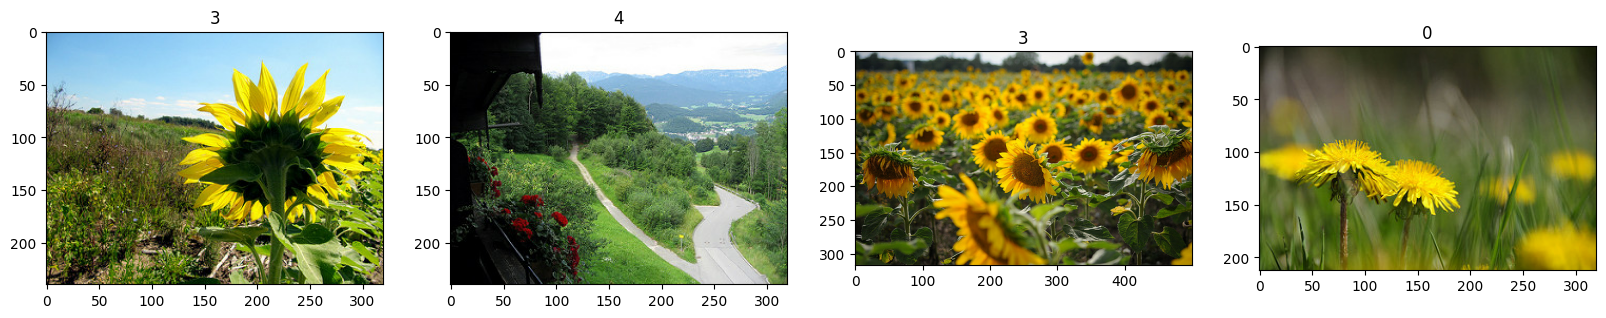

In [299]:
#plot images
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx in range(4):
    #pega um novo batch
    batch=dataiterator.next()
    #plota a imagem
    ax[idx].imshow(np.squeeze(batch['image']))
    #adiciona a label
    ax[idx].title.set_text(batch['label'])

In [300]:
def format_images(data):
    image = tf.image.resize(data['image'],(128,128))/255
    return image

In [301]:
ds = ds.map(format_images)
ds = ds.cache()
ds = ds.shuffle(6000)
ds = ds.batch(1)
ds = ds.prefetch(64)
ds.as_numpy_iterator().next().shape

(1, 128, 128, 3)

In [302]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, MaxPooling2D

In [303]:
def build_generator():
    model = Sequential()

    model.add(Dense(16*16*128,input_dim=1)) #shape=(16,16,128)
    model.add(LeakyReLU(0.2))
    model.add(Reshape((16,16,128)))

    model.add(UpSampling2D()) #shape=32
    model.add(Conv2D(128,5,padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(UpSampling2D()) #shape=64
    model.add(Conv2D(128,5,padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(UpSampling2D()) #shape=128
    model.add(Conv2D(128,5,padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(128,5,padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128,4,padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128,4,padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(3,4,padding='same',activation='sigmoid'))

    return model

In [304]:
generator = build_generator()
generator.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 32768)             65536     
                                                                 
 leaky_re_lu_135 (LeakyReLU)  (None, 32768)            0         
                                                                 
 reshape_15 (Reshape)        (None, 16, 16, 128)       0         
                                                                 
 up_sampling2d_39 (UpSamplin  (None, 32, 32, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_125 (Conv2D)         (None, 32, 32, 128)       409728    
                                                                 
 leaky_re_lu_136 (LeakyReLU)  (None, 32, 32, 128)      0         
                                                     

In [305]:
imgs = generator.predict(np.random.randn(4,1,1))
imgs.shape

1/1 [==============================] - 0s 99ms/step


(4, 128, 128, 3)

1/1 [==============================] - 0s 18ms/step


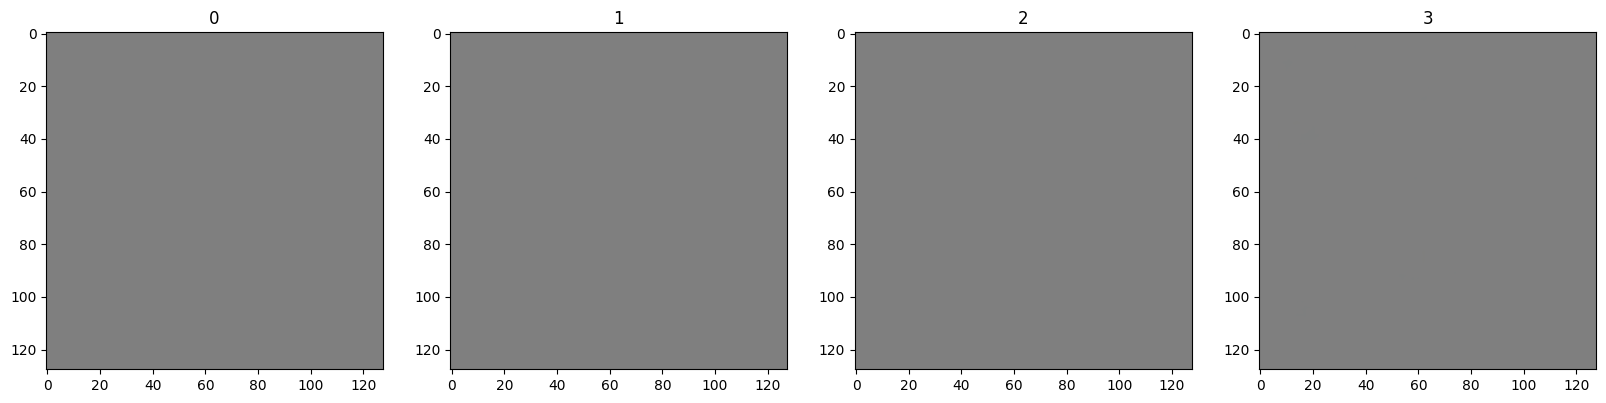

In [306]:
#plota imagens NÃO TREINADAS
imgs = generator.predict(np.random.randn(4,1,1))
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(imgs):
    #plota a imagem
    ax[idx].imshow(np.squeeze(img))
    #adiciona a label
    ax[idx].title.set_text(idx)

In [307]:
def build_discriminator():
    model = Sequential()

    model.add(Conv2D(32,5,input_shape=(128,128,3)))
    #model.add(MaxPooling2D())
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.6))

    model.add(Conv2D(64,5))
    #model.add(MaxPooling2D())
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    '''model.add(Conv2D(128,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))'''

    '''model.add(Conv2D(256,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))'''

    model.add(Flatten())
    model.add(Dropout(0.4))

    model.add(Dense(1,activation='sigmoid'))

    return model

In [308]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_132 (Conv2D)         (None, 124, 124, 32)      2432      
                                                                 
 leaky_re_lu_142 (LeakyReLU)  (None, 124, 124, 32)     0         
                                                                 
 dropout_58 (Dropout)        (None, 124, 124, 32)      0         
                                                                 
 conv2d_133 (Conv2D)         (None, 120, 120, 64)      51264     
                                                                 
 leaky_re_lu_143 (LeakyReLU)  (None, 120, 120, 64)     0         
                                                                 
 dropout_59 (Dropout)        (None, 120, 120, 64)      0         
                                                                 
 flatten_16 (Flatten)        (None, 921600)          

In [309]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model

g_opt=Adam(learning_rate=0.0001)
d_opt=Adam(learning_rate=0.00001) # mais lento que o generator
g_loss=BinaryCrossentropy()
d_loss=BinaryCrossentropy()

In [310]:
class flowerGAN(Model):
    def __init__(self,generator,discriminator,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.generator = generator
        self.discriminator = discriminator
    
    def compile(self,g_opt,d_opt,g_loss,d_loss,*args,**kwargs):
        super().compile(*args,**kwargs)
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self,batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((128,1,1)),training=False)

        with tf.GradientTape() as d_tape:

            yhat_real = self.discriminator(real_images,training=True)
            yhat_fake = self.discriminator(fake_images,training=True)
            yhat_realfake = tf.concat([yhat_real,yhat_fake],axis=0)

            y_realfake = tf.concat([tf.zeros_like(yhat_real),tf.ones_like(yhat_fake)],axis=0)

            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real,noise_fake],axis=0)

            total_d_loss = self.d_loss(y_realfake,yhat_realfake)
        
        dgrad = d_tape.gradient(total_d_loss,self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad,self.discriminator.trainable_variables))

        with tf.GradientTape() as g_tape:

            gen_images = self.generator(tf.random.normal((128,1,1)),training=True)

            predicted_labels = self.discriminator(gen_images,training=False)

            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels),predicted_labels)

        ggrad = g_tape.gradient(total_g_loss,self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad,self.generator.trainable_variables))

        return {'d_loss': total_d_loss, 'g_loss':total_g_loss}

In [311]:
flwrGAN = flowerGAN(generator,discriminator)

In [312]:
flwrGAN.compile(g_opt,d_opt,g_loss,d_loss)

In [313]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [314]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3,latent_dim=1):
        self.num_img=num_img
        self.latent_dim=latent_dim

    def on_epoch_end(self,epoch,logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img,self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images*=255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images-flowers',f'generated)img_{epoch}_{i}.png'))

In [315]:
hist = flwrGAN.fit(ds,epochs=3,callbacks=[ModelMonitor()])

Epoch 1/3


ResourceExhaustedError: Graph execution error:

OOM when allocating tensor with shape[128,128,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_31/conv2d_127/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_36624]

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'],label='d_loss')
plt.plot(hist.history['g_loss'],label='g_loss')
plt.legend
plt.show()

In [ ]:
# Imagens TREINADAS

imgs=generator.predict(tf.random.uniform((16,128,1)))
fig, ax = plt.subplots(ncols=4,nrows=4,figsize=(20,20))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

In [ ]:

generator.save("generator-tfflower.h5")
discriminator.save('discriminator-tfflower.h5')